In [28]:
import numpy as np
from matplotlib import pyplot as plt
from IPython import display

np.random.seed(0)

import torch

# which folder
folder_index = 1

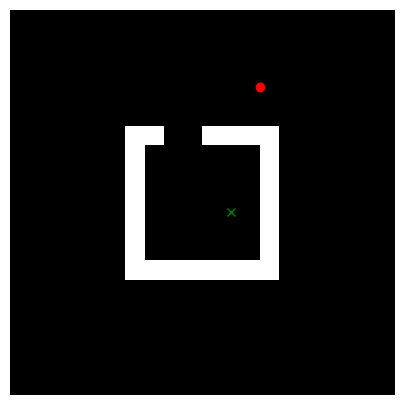

In [3]:
from grid_env import GridEnv
env = GridEnv(sparse=True)
env.plot()

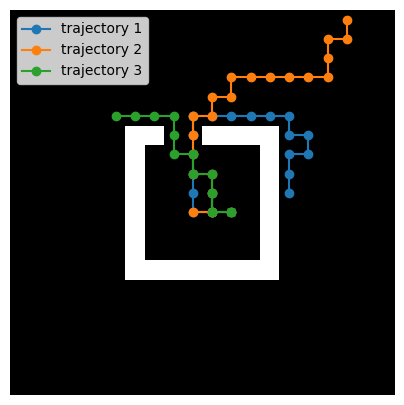

In [4]:
# load the trajectories
import pickle
with open('world_{folder_index}/trajs.pkl','rb') as f:
    trajs = pickle.load(f)

# plot the trajectories
num_plot = 3
plt.figure(figsize=(5,5))
plt.imshow(env.occ_map.T, origin="lower",extent=[0,env.N,0,env.N], cmap='gray')
plt.plot(env.xl+0.5,env.yl+0.5,'gx') # goal location
for i in range(num_plot):
    plt.plot(trajs[i][:,0]+0.5,trajs[i][:,1]+0.5, '-o',label=f'trajectory {i+1}')
# finish up the rest of the plot settings
plt.legend()
plt.axis('off')
plt.show()

In [6]:
print("The length of the trajectory set is: " + str(len(trajs)))
print("The length of the first trajectory is: " + str(len(trajs[0])))

The length of the trajectory set is: 150
The length of the first trajectory is: 23


In [18]:
# manually create a dataset from the trajectories.
# the input is a pair of states, the output is the preference label: 0 if the first state is prefered, 1 if the second state is prefered.
# the preference is defined as the state whose index is larger in the trajectory.
# the state pairs are randomly samples from the same randomly chosen trajectory.

# the number of state pairs to sample
num_pairs = 10000
# the number of trajectories
num_traj = len(trajs)
# state length
state_len = len(trajs[0][0])
# noise in the preference assignment
noise = 0.1
# initialise dataset
state_pairs = torch.zeros((num_pairs,2,state_len))
preferences = torch.zeros((num_pairs,1))

for i in range(num_pairs):
    # randomly choose a trajectory
    traj = trajs[np.random.randint(num_traj)]
    # randomly choose two distinct states from the trajectory
    idx1, idx2 = np.random.choice(len(traj),2,replace=False)
    s1 = traj[idx1]
    s2 = traj[idx2]
    # assign the state pair to the state pair tensor
    state_pairs[i,0,:] = torch.tensor(s1)
    state_pairs[i,1,:] = torch.tensor(s2)
    # whichever state has the larger index is prefered, with some noise
    if np.random.rand() > noise:
        if idx1 > idx2:
            pref = 0
        else:
            pref = 1
    else:
        # randomly assign preference from 0 or 1
        pref = np.random.randint(2)
    # assign the preference to the preference tensor
    preferences[i,0] = pref
    

In [19]:
print("The shape of the state pairs are: \n" + str(state_pairs.size()))
print("Example of a state pair: " + str(state_pairs[0]))
print("")
print("The shape of the preferences are: \n" + str(preferences.size()))
print("The preferences are: " + str(preferences))


The shape of the state pairs are: 
torch.Size([10000, 2, 2])
Example of a state pair: tensor([[10., 11.],
        [13., 14.]])

The shape of the preferences are: 
torch.Size([10000, 1])
The preferences are: tensor([[0.],
        [0.],
        [1.],
        ...,
        [0.],
        [1.],
        [0.]])


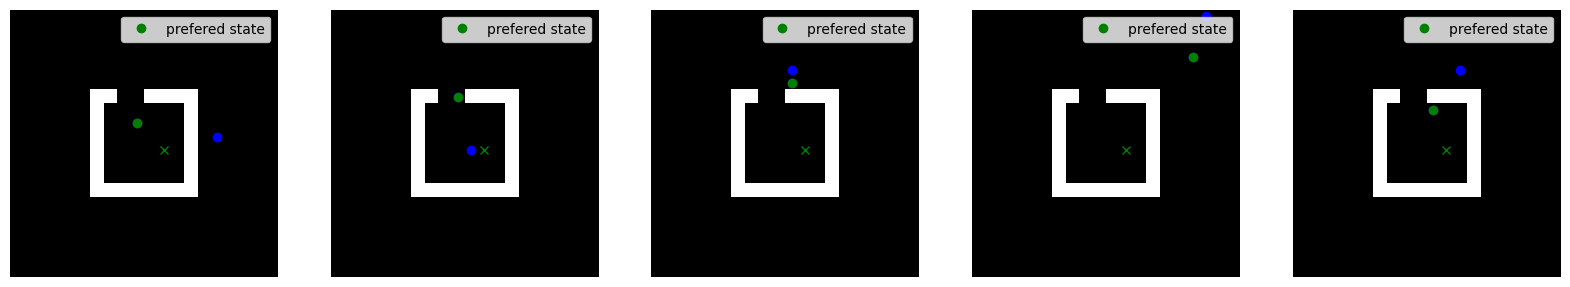

In [26]:
# select 5 random pairs of states, and colour the state that is prefered in green
num_plot = 5
# create subplots
fig, axs = plt.subplots(1, num_plot, figsize=(20,5))
# plot each state pair
for i in range(num_plot):
    # randomly choose a state pair
    idx = np.random.randint(num_pairs)
    s1 = state_pairs[idx,0,:]
    s2 = state_pairs[idx,1,:]
    p = preferences[idx,0]
    # plot the first state
    axs[i].imshow(env.occ_map.T, origin="lower",extent=[0,env.N,0,env.N], cmap='gray')
    axs[i].plot(env.xl+0.5,env.yl+0.5,'gx') # goal location
    axs[i].plot(s1[0]+0.5,s1[1]+0.5,'bo')
    # plot the second state
    axs[i].plot(s2[0]+0.5,s2[1]+0.5,'bo')
    # plot the prefered state in green
    if p == 0:
        axs[i].plot(s1[0]+0.5,s1[1]+0.5,'go', label='prefered state')
    else:
        axs[i].plot(s2[0]+0.5,s2[1]+0.5,'go', label='prefered state')
    # finish up the rest of the plot settings
    axs[i].legend()
    axs[i].axis('off')

In [29]:
# save the dataset tensors into files
torch.save(state_pairs, f'world_{folder_index}/state_pairs.pt')
torch.save(preferences, f'world_{folder_index}/preferences.pt')